# Machine learning assignment 3: Lasso Regression

## Summary
I am using the bike sharing dataset of https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset, which provides data on how many bikes are rent out on specific hours of specific days, the weather on these days, whether the day was a weekday or not, etc. I would like to predict how many bikes are rent out.

A lasso regression analysis was conducted to identify a subset of variables from a pool of 10 categorical and quantitative predictor variables that best predicted the number of rented out bikes. These variables are related to the weather and the kind of day (weekday, holiday, month, season) it is. All predictor variables were standardized to have a mean of zero and a standard deviation of one.

Data were randomly split into a training set that included 70% of the observations (N=511) and a test set that included 30% of the observations (N=220). The least angle regression algorithm with k=10 fold cross validation was used to estimate the lasso regression model in the training set, and the model was validated using the test set. The change in the cross validation average (mean) squared error at each step was used to identify the best subset of predictor variables. 

All of the 10 variables were retained in the selected model. Variables regarding the month number and the temperature are most strongly associated with the number of rented out bikes. The 10 variables accounted for 78.8% of the variance in the number of rented out bikes.

## Loading data

In [27]:
%matplotlib inline
import numpy
import pandas

data = pandas.read_csv('day.csv', low_memory=False)
print("Number of observations: ", len(data))
data.head()

Number of observations:  731


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Managing data
Adding month number, selecting relevant variables

In [28]:
data['month_no'] = data['yr']*12+data['mnth']

In [29]:
selected_vars = ['season','month_no','mnth','holiday','weekday','workingday','weathersit','temp','atemp','windspeed']
predvar = data[selected_vars]
target = data.cnt

### Standardize predictors to have mean = 0 and sd = 1

In [46]:
predictors=predvar.copy()
from sklearn import preprocessing
for var in selected_vars:
    predictors[var] = preprocessing.scale(predictors[var].astype('float64'))
predictors.head()

,season,month_no,mnth,holiday,weekday,workingday,weathersit,temp,atemp,windspeed
0,-1.348213,-1.666969,-1.600161,-0.171981,1.498809,-1.471225,1.110427,-0.826662,-0.679946,-0.387892
1,-1.348213,-1.666969,-1.600161,-0.171981,-1.496077,-1.471225,1.110427,-0.721095,-0.740652,0.749602
2,-1.348213,-1.666969,-1.600161,-0.171981,-0.996930,0.679706,-0.726048,-1.634657,-1.749767,0.746632
3,-1.348213,-1.666969,-1.600161,-0.171981,-0.497782,0.679706,-0.726048,-1.614780,-1.610270,-0.389829
4,-1.348213,-1.666969,-1.600161,-0.171981,0.001366,0.679706,-0.726048,-1.467414,-1.504971,-0.046307


## Learning the model

In [31]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, 
                                                              test_size=.3, random_state=666)
    

In [32]:
model = LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

## Model properties

### regression coefficients

In [33]:
coefs = dict(zip(predictors.columns, model.coef_))

In [34]:
sorted(coefs.items(), key=lambda x: abs(x[1]))

[('holiday', -49.608354767979186),
 ('workingday', 108.70774492889042),
 ('weekday', 144.57152039598276),
 ('windspeed', -163.15070876883951),
 ('atemp', 240.5029602621282),
 ('weathersit', -420.85228213486153),
 ('season', 611.55381534000935),
 ('temp', 700.8666533041694),
 ('mnth', -779.64243607401625),
 ('month_no', 1178.3107871393743)]

### regression progression

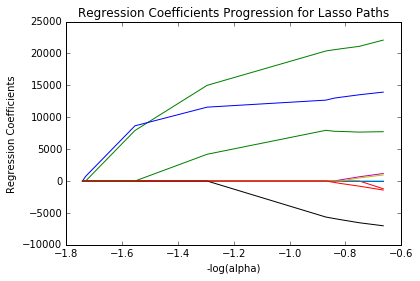

In [48]:
import matplotlib.pyplot as plt
m_log_alphas = -numpy.log10(model.alphas_)
pl = plt.plot(m_log_alphas, model.coef_path_.T)
#plt.legend(pl, predictors.columns, loc='best')
plt.axvline(-numpy.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths');

### mean square error for each fold

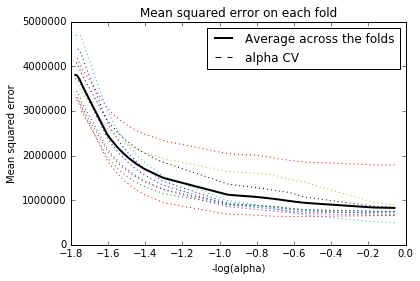

In [49]:
m_log_alphascv = -numpy.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-numpy.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold');

### mean square error on test and training data

In [68]:
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)
print('average number of rented out bikes ',numpy.mean(data['cnt']))
mean_arr = numpy.full(len(tar_test), numpy.mean(data['cnt']))
print('MSE of always predicting the mean: ', mean_squared_error(tar_test, mean_arr))

training data MSE
767285.223995
test data MSE
760598.11618
average number of rented out bikes  4504.3488372093025
MSE of always predicting the mean:  3623151.3627


In [51]:
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data R-square
0.797924976672
test data R-square
0.788743687738
